In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
#import warnings
from copy import deepcopy

from Classes.marketmodel_interface import MarketModel
from Classes.simulation_interface import Simulation

#### Import data for calibration
CAC40

In [2]:
# Create dictionary to store dataFrames for the 40 CAC40 companies
Data10y_dic = {}

# Get list of files containing 'Data' in the "Data/CAC40 daily 10y"
directory = "Data/CAC40 daily 10y"
files = [f for f in os.listdir(directory) if 'Data' in f]
# Process each file
for file in files:
    # Get company name (first word before '_')
    company = file.split('_')[0]
    
    # Read the file with tab separator
    df = pd.read_csv(os.path.join(directory, file), sep='\t')
    
    # Convert first column to datetime and set as index
    df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

    df = df.drop('date', axis=1)  # Remove the original date column
    df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
    
    # Store in dictionary
    Data10y_dic[company] = df

# Create a DataFrame with all the closing prices
dfs = [df['clot'] for df in Data10y_dic.values()]
histo_CAC40 = pd.concat(dfs, axis=1, keys=Data10y_dic.keys())
histo_CAC40 = histo_CAC40.sort_index()

data = histo_CAC40.dropna()
nb_stocks = 40
allocations_EW = np.ones(nb_stocks) / nb_stocks
# Import the weights data of CAC40
CAC40_weights_df = pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Company')
# Convert string values to float
CAC40_weights = CAC40_weights_df.iloc[0, :].str.replace(',', '.').astype(float).values

In [3]:
logreturn_data = np.log(data / data.shift() )
logreturn_data.iloc[0,:] = 0.0

begin_date_data = str(data.index[0])[:10]
end_date_data = str(data.index[-1])[:10]

print(begin_date_data)
print(end_date_data)

data

2018-06-05
2025-03-07


,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
date,,,,,,,,,,,,,,,,,,,,,
2018-06-05,45.22,98.98,81.382,28.680,21.730,53.12,39.52,20.858,114.80,14.326,...,73.80,33.963,11.028,21.160,136.50,108.70,48.840,192.45,18.686,82.435
2018-06-06,45.04,100.00,82.206,29.485,21.630,53.69,39.82,20.956,114.70,14.103,...,73.94,33.885,11.186,21.460,136.40,108.40,49.233,192.20,18.512,82.474
2018-06-07,44.00,99.65,82.056,28.750,21.800,54.11,39.62,20.868,113.45,14.075,...,74.20,34.127,11.279,21.240,136.70,108.05,49.849,193.70,18.531,82.144
2018-06-08,43.40,100.90,82.056,28.045,21.800,53.70,39.18,21.112,113.20,13.908,...,73.60,33.908,11.219,21.040,137.30,110.35,49.587,192.10,18.406,81.853
2018-06-11,43.75,100.90,83.031,28.600,21.985,54.68,39.36,21.122,113.60,13.968,...,74.24,34.445,11.159,21.350,137.40,109.60,49.871,189.60,18.478,81.989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-03,48.62,174.38,179.680,28.800,38.150,74.02,33.22,29.120,148.20,12.550,...,229.65,39.585,12.322,23.770,97.88,222.40,58.170,81.24,29.160,111.650
2025-03-04,46.83,168.74,177.860,27.310,37.960,71.69,33.51,28.980,143.25,12.670,...,218.80,38.470,11.066,21.800,95.12,228.00,56.610,81.50,29.340,111.750
2025-03-05,47.66,172.78,180.920,30.170,38.320,74.66,34.88,28.960,150.70,12.730,...,226.15,40.460,11.580,22.975,100.25,245.40,55.980,79.34,30.080,117.400


#### Calibration heston

In [4]:
market_model_Heston_CAC40 = MarketModel(model_name="Heston")
market_model_Heston_CAC40.fit(data)

In [16]:
market_model_Heston_CAC40.parameters['Parameters Heston']['LVMH']

parameters
V_end     0.08287
S_end       634.7
mu       0.040256
kappa    12.89004
theta    0.104647
sigma    0.529783
Name: LVMH, dtype: object

In [6]:
# change mu
mu = market_model_Heston_CAC40.parameters['Parameters Heston'].loc['mu']
mu = (mu-0.02)*1/10 + 0.02
market_model_Heston_CAC40.parameters['Parameters Heston'].loc['mu'] = mu
market_model_Heston_CAC40.parameters['Parameters Heston'] 

companies,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
parameters,,,,,,,,,,,,,,,,,,,,,
V_end,0.110399,0.135281,0.046319,0.616708,0.036018,0.110244,0.128203,0.055845,0.502108,0.244228,...,0.213609,0.143049,0.469095,0.643019,0.565485,0.259379,0.029189,0.082893,0.031138,0.079732
S_end,46.59,169.56,180.3,30.48,38.76,76.57,35.59,29.24,153.75,13.03,...,223.9,42.075,11.638,23.725,102.6,236.7,56.54,75.2,30.77,117.0
mu,0.025053,0.029765,0.035102,0.017981,0.029717,0.026487,0.019746,0.026695,0.033003,0.013828,...,0.045371,0.027847,0.022907,0.028364,0.015345,0.023721,0.016311,0.002072,0.032381,0.028597
kappa,6.149225,4.6946,8.805921,9.607523,7.350713,8.612842,7.726957,7.922312,8.547853,14.456934,...,8.767926,9.446842,10.017863,14.66428,8.98113,8.821563,6.077927,4.405002,6.358397,4.678861
theta,0.12924,0.17206,0.049048,0.22794,0.075874,0.121308,0.092742,0.064704,0.123681,0.089644,...,0.098775,0.171654,0.168938,0.204713,0.212669,0.095373,0.091468,0.240551,0.087477,0.089825
sigma,0.802926,1.565224,0.314213,1.208319,0.739079,0.621973,0.765778,0.366919,0.595277,0.606541,...,0.530565,1.049015,1.04349,1.034213,3.16906,0.505525,0.767188,1.630307,0.611724,0.768895


In [7]:
market_model_Heston_CAC40.parameters['dB_dW correlation']

,ACCOR_dB,AIRBUS_dB,AIRLIQUIDE_dB,ARCELORMITTAL_dB,AXA_dB,BNPPARIBAS_dB,BOUYGUES_dB,BUREAUVERITAS_dB,CAPGEMINI_dB,CARREFOUR_dB,...,SCHNEIDERELECTRIC_dW,SOCIETEGENERALE_dW,STELLANTIS_dW,STMICROELECTRONICS_dW,TELEPERFORMANCE_dW,THALES_dW,TOTALENERGIES_dW,UNIBAILRODAMCOWESTFIELD_dW,VEOLIA_dW,VINCI_dW
ACCOR_dB,1.000000,0.501028,0.334885,0.433790,0.454115,0.490642,0.436118,0.314627,0.340729,0.208436,...,-0.039465,-0.066532,-0.075274,-0.070149,0.038865,-0.003829,-0.128087,-0.064177,-0.071337,-0.106238
AIRBUS_dB,0.501028,1.000000,0.402471,0.446868,0.459735,0.437253,0.437603,0.348013,0.364594,0.168653,...,-0.092930,-0.097363,-0.093155,-0.093638,-0.013315,-0.039667,-0.129030,-0.047410,-0.087166,-0.113498
AIRLIQUIDE_dB,0.334885,0.402471,1.000000,0.341040,0.430643,0.350252,0.381222,0.414371,0.415701,0.212288,...,-0.060131,-0.070538,-0.044637,-0.074706,0.019253,-0.030167,-0.119924,-0.077434,-0.082625,-0.073554
ARCELORMITTAL_dB,0.433790,0.446868,0.341040,1.000000,0.485049,0.568033,0.422247,0.318475,0.355456,0.250437,...,-0.085421,-0.054898,-0.069061,-0.048838,0.021828,-0.008553,-0.129056,-0.063550,-0.110503,-0.089428
AXA_dB,0.454115,0.459735,0.430643,0.485049,1.000000,0.660828,0.519201,0.346750,0.357765,0.297899,...,-0.043311,-0.081851,-0.069035,-0.031328,0.002849,-0.028507,-0.128526,-0.088646,-0.110033,-0.102986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
THALES_dW,-0.003829,-0.039667,-0.030167,-0.008553,-0.028507,-0.030662,-0.027311,-0.011362,-0.000633,-0.039954,...,0.191787,0.205810,0.193223,0.124760,0.051203,1.000000,0.324705,0.206105,0.256257,0.312042
TOTALENERGIES_dW,-0.128087,-0.129030,-0.119924,-0.129056,-0.128526,-0.105964,-0.101826,-0.062460,-0.066620,-0.072053,...,0.398123,0.353002,0.424367,0.261926,0.038686,0.324705,1.000000,0.410077,0.465511,0.552137
UNIBAILRODAMCOWESTFIELD_dW,-0.064177,-0.047410,-0.077434,-0.063550,-0.088646,-0.073170,-0.070784,-0.059718,-0.058472,-0.088020,...,0.291123,0.249221,0.422249,0.282988,0.117637,0.206105,0.410077,1.000000,0.470597,0.501835
VEOLIA_dW,-0.071337,-0.087166,-0.082625,-0.110503,-0.110033,-0.093358,-0.112970,-0.036684,-0.049279,-0.114297,...,0.429045,0.384200,0.425933,0.282164,0.067270,0.256257,0.465511,0.470597,1.000000,0.590248


#### Simulation with historical data

In [8]:
nb_simu = 200

allocations = np.ones(nb_stocks) / nb_stocks
#allocations = CAC40_weights
# Simulate the market model

parameters_BuyH = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Allocation": allocations,
}

Data_esg = (pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Company').iloc[1:, :]).T
#string to float
Data_esg = Data_esg.apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)
constraints = {
    "List" : ["Maximal allocation", "Maximal volatility"],
    "Value" : [0.1, 0.4]
}

simulation_BuyH = Simulation(nb_scenarios=nb_simu, model=market_model_Heston_CAC40, strategy="Buy and hold", parameters=parameters_BuyH, rf = 0.02)
simulation_BuyH.set_dataESG(Data_esg)
simulation_BuyH.set_constraints(constraints)
simulation_BuyH.generate_scenarios()
simulation_BuyH.generate_evolutions()

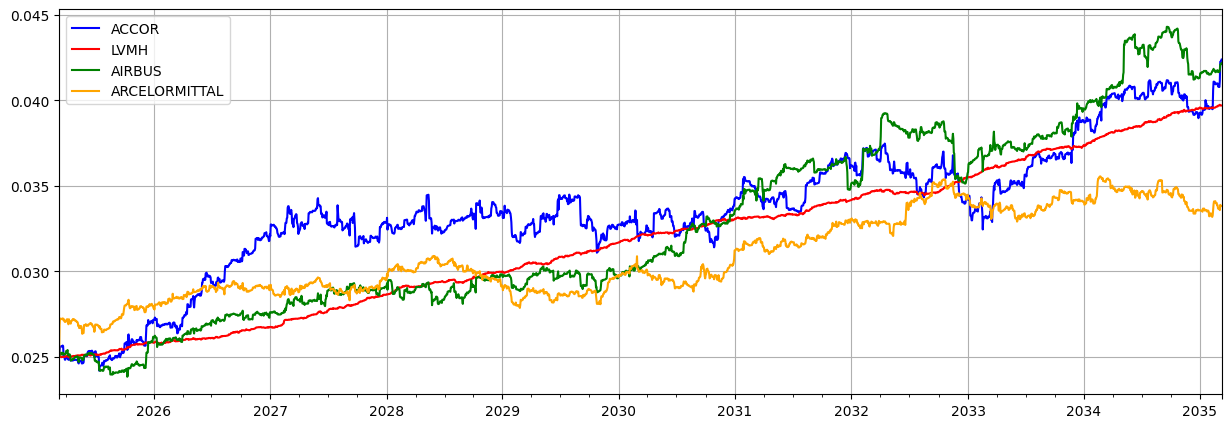

In [20]:
simulation_BuyH.evolutions['Evolution 4']['ACCOR'].plot(figsize=(15, 5), color='blue')
simulation_BuyH.evolutions['Evolution 4']['LVMH'].plot( figsize=(15, 5), color='red')
simulation_BuyH.evolutions['Evolution 4']['AIRBUS'].plot( figsize=(15, 5), color='green')
simulation_BuyH.evolutions['Evolution 4']['ARCELORMITTAL'].plot( figsize=(15, 5), color='orange')
plt.legend()
plt.grid()

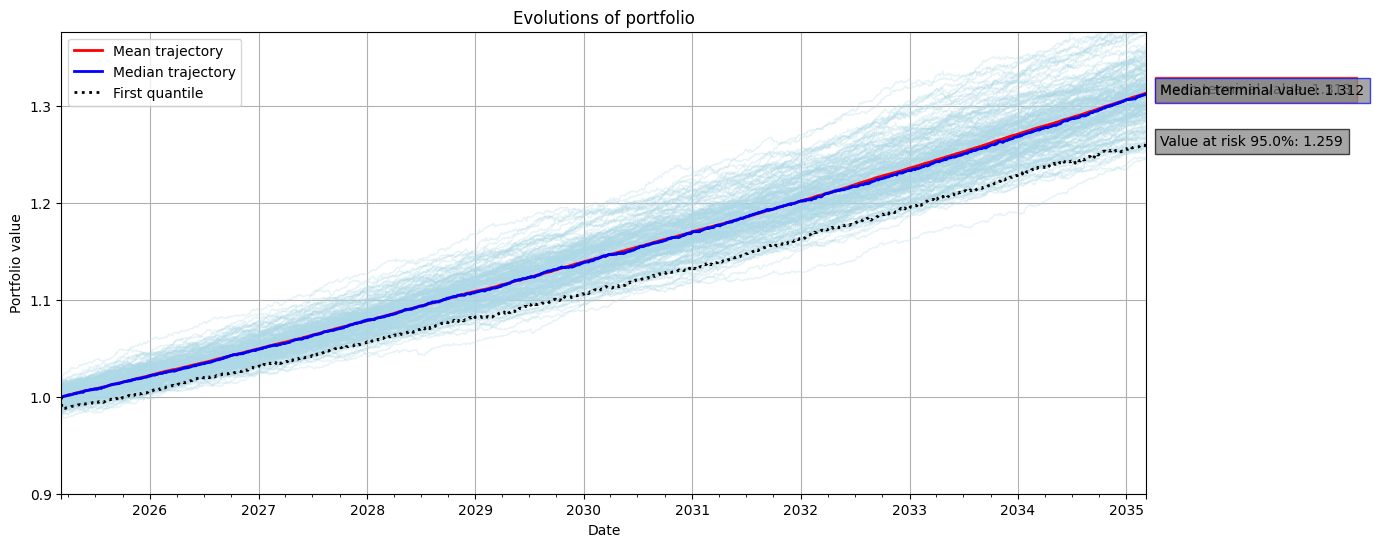

In [10]:
simulation_BuyH.plot()